##  Imports

In [1]:
import os
import sys
from datetime import datetime

import numpy as np
import pandas as pd
import cv2
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from matplotlib import pyplot as plt

In [2]:
from data_handler.FaceMaskData import FaceMaskData
from data_handler.FaceMaskDataset import FaceMaskDataset
from trainer import *

In [3]:
# %load_ext tensorboard 

In [4]:
assert torch.cuda.is_available()

## Configurations

In [5]:
class CFG:
    seed = 42
    model_name = 'faster_rcnn'
    pretrained = True
    img_width = 480
    img_height = 480
    batch_size = 10
    n_epochs = 1
    n_folds = 5
    drop_rate = 0.
    train_size = 0.85
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    num_workers=4
    num_classes=4

np.random.seed(CFG.seed)

## Data Load

Define transformations

In [6]:
train_transforms = A.Compose([
            ToTensorV2(p=1.0) 
], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

valid_transforms = A.Compose([
            ToTensorV2(p=1.0)
], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

Load the data into a dataset

In [7]:
imgs_path = 'images'        #   images dir
msks_path = 'annotations'   #   annotations dir

faceMasksData = FaceMaskData(imgs_path, msks_path)
(x_train, y_train), (x_test, y_test) = faceMasksData.load_data(drop_rate=CFG.drop_rate)

trainset = FaceMaskDataset(x_train, y_train, imgs_path, msks_path, CFG.img_width, CFG.img_height, transforms=train_transforms)
validset = FaceMaskDataset(x_test, y_test, imgs_path, msks_path, CFG.img_width, CFG.img_height, transforms=valid_transforms)

print('Training contains {} samples which is {:g}% of the data'.format(len(trainset), len(trainset) * 100 / (len(trainset) + len(validset))))
print('Validation contains {} samples which is {:g}% of the data'.format(len(validset), len(validset) * 100 / (len(trainset) + len(validset))))

Training contains 682 samples which is 79.9531% of the data
Validation contains 171 samples which is 20.0469% of the data


Define collate function for PyTorch's Dataloader, as the data shape is not consistant

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [9]:
train_loader = DataLoader(dataset=trainset, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, collate_fn=collate_fn)
valid_loader = DataLoader(dataset=validset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, collate_fn=collate_fn)

In [10]:
dataloaders = { 'train': train_loader,
                'valid': valid_loader }

## Data Exploration

In [11]:
df = pd.read_csv(os.path.join(sys.path[0], 'annotation.csv'))
df.head()

xmin  ymin  xmax  ymax                   name             file  width  \
0    28    55    46    71              with_mask  maksssksksss737    400   
1    98    62   111    78              with_mask  maksssksksss737    400   
2   159    50   193    90  mask_weared_incorrect  maksssksksss737    400   
3   293    59   313    80              with_mask  maksssksksss737    400   
4   352    51   372    72              with_mask  maksssksksss737    400   

   height  class    Xcent     Ycent    boxW      boxH  
0     226      0  0.09250  0.278761  0.0450  0.070796  
1     226      0  0.26125  0.309735  0.0325  0.070796  
2     226      1  0.44000  0.309735  0.0850  0.176991  
3     226      0  0.75750  0.307522  0.0500  0.092920  
4     226      0  0.90500  0.272124  0.0500  0.092920

### Images and labels count

In [12]:
faces = len(df['file'].unique())
annotates = len(df)
print('There are total {} images in the data'.format(faces))
print('There are total {} annotated faces in the data'.format(annotates))
print('Average of {:.5f} per image'.format(annotates/faces))

There are total 853 images in the data
There are total 4072 annotated faces in the data
Average of 4.77374 per image


label count
0              with_mask  3232
1           without_mask   717
2  mask_weared_incorrect   123

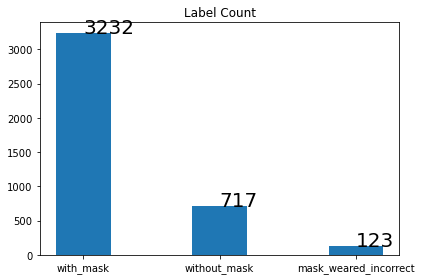

In [13]:
label_df = pd.DataFrame(columns=['label', 'count'])
for k, v in df['name'].value_counts().to_dict().items():
    label_df = label_df.append({'label':k, 'count':v}, ignore_index=True)
    
display(label_df)

fig, ax = plt.subplots()
ax.bar(label_df['label'], label_df['count'], width=0.4)
plt.title('Label Count')
for index, data in enumerate(label_df['count']):
    plt.text(x=index, y=data+1, s=data , fontdict=dict(fontsize=20))
plt.tight_layout()
plt.show()

In [14]:
def get_num_faces(df,image_name_col):
    max_faces = find_max_faces(df,image_name_col)
    arr = [0] * (max_faces + 1)
    faces_count =1
    current_img =df.at[0,image_name_col]
    for i in range(1,len(df[1:])):
        if current_img == df.at[i,image_name_col]:
            faces_count = faces_count +1
        else:
            arr[faces_count] = arr[faces_count] +1
            faces_count =1
            current_img =df.at[i,image_name_col]
    
    df = pd.DataFrame(columns=['faces', 'count'])
    for i, val in enumerate(arr):
        if val > 0:
            df = df.append({'faces': i, 'count': val}, ignore_index=True)
    return df

def find_max_faces(df,image_name_col):
    max_faces=1
    faces_count =1
    current_img =df.at[0,image_name_col]  
    for i in range(1,len(df[1:])):
        if current_img == df.at[i,image_name_col]:
          faces_count = faces_count +1
        else:
            if faces_count > max_faces:
                max_faces = faces_count
            current_img = df.at[i,image_name_col]  
            faces_count =1
    return max_faces

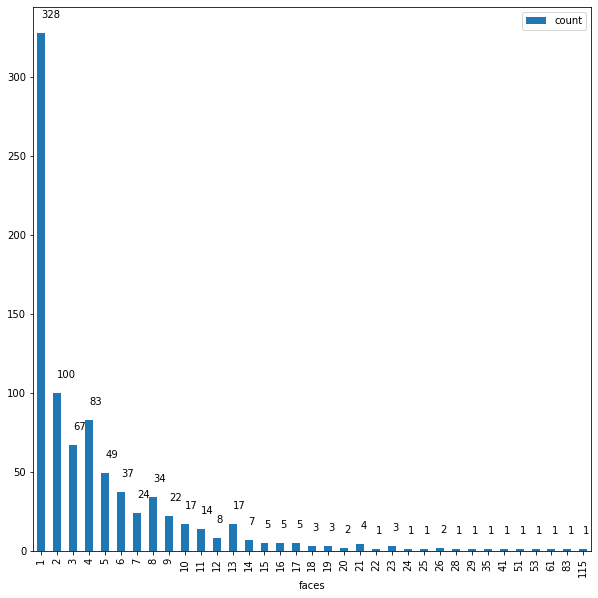

In [15]:
face_dist_df = get_num_faces(df, 'file')

ax = face_dist_df.plot.bar(x='faces', y='count', figsize=(10,10))
for idx, label in enumerate(list(face_dist_df.faces)): 
    val = int(face_dist_df[face_dist_df['faces']==label]['count'])
    ax.annotate(val,
                (idx, val),
                 xytext=(0, 15), 
                     textcoords='offset points')

In [16]:
print('STD of faces in the images: {:.5}'.format(face_dist_df['count'].std()))

STD of faces in the images: 58.229


In [17]:
def labels2index(labels):
    all = np.array(['mask', 'without_mask', 'mask_weared_incorrect',
          'mask/without_mask', 'mask/mask_weared_incorrect',
           'without_mask/mask_weared_incorrect',
          'mask/without_mask/mask_weared_incorrect'])
    
    labels_conn = ''
    if 'mask' in labels:
        labels += 'mask'
    

for name in faceMasksData.images:
    filename = name.split('.')[0]
    tmp_df = df[df['file']==filename]
    print(tmp_df)
    break

     xmin  ymin  xmax  ymax          name           file  width  height  \
978    79   105   109   142  without_mask  maksssksksss0    512     366   
979   185   100   226   144     with_mask  maksssksksss0    512     366   
980   325    90   360   141  without_mask  maksssksksss0    512     366   

     class     Xcent     Ycent      boxW      boxH  
978      2  0.183594  0.337432  0.058594  0.101093  
979      0  0.401367  0.333333  0.080078  0.120219  
980      2  0.668945  0.315574  0.068359  0.139344  


## Train Examples

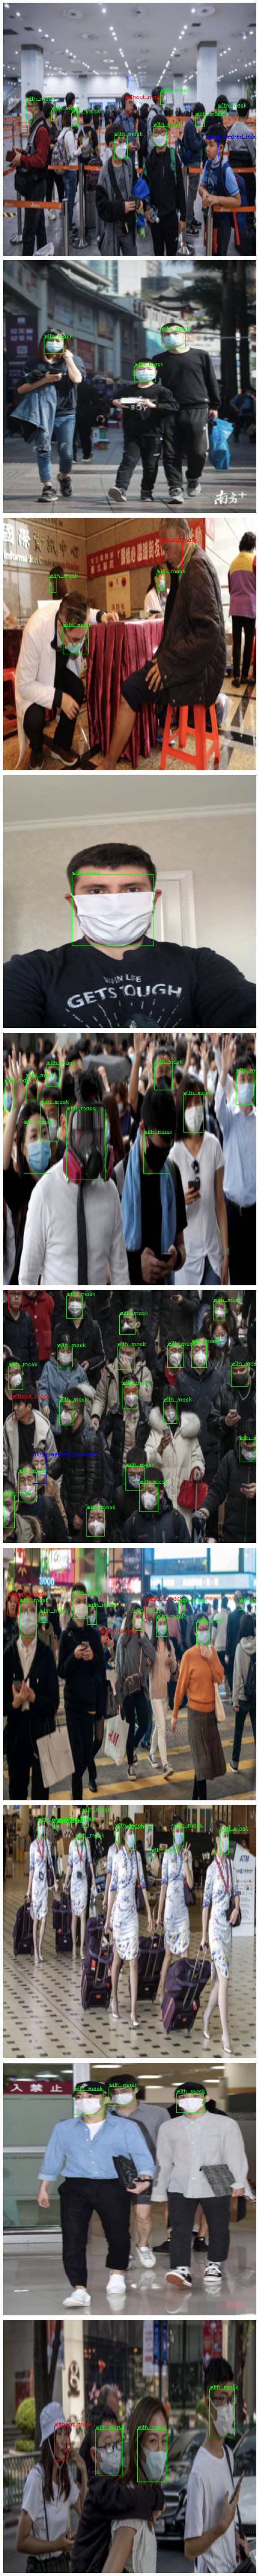

In [18]:
def norm(img):
    img = np.array(img, dtype=np.float32)
    img -= img.min()
    img /= img.max()
    return img

def get_annotated_img(img, annt, is_pred=False):
    img = np.array(np.transpose(img, (1, 2, 0))) * 255.0    #   multiple by 255 as in the dataset we divide it
                                                                #   needed here because the image come from the dataset in values of [0, 1]
                                                                #   and the annotations are in values of [0, 255] and plt should get images
                                                                #   with values of [0, 1], therefore a normalizing of the images is needed
        
    for box, cat in zip(annt['boxes'], annt['labels']):
        xmin, ymin, xmax, ymax = np.array(box, dtype=np.int32)
        start_point = (xmin, ymin)
        end_point = (xmax, ymax)
        
#         [None, 'without_mask','with_mask','mask_weared_incorrect']
        color = (0, 0, 0)
        if cat == 2:
            color = (0, 255, 0) # green
        elif cat == 3:
            color = (0, 0, 255) # blue
        elif cat == 1:
            color = (255, 0, 0) # red
        thickness = 1
        img = cv2.rectangle(img, start_point, end_point, color, thickness)

        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1 / 3
        if not is_pred:
            img = cv2.putText(img, '{}'.format(validset.classes[cat]), start_point, font, fontScale, color, thickness, cv2.LINE_AA)
        else:
            img = cv2.putText(img, '{} {:.5f}'.format(validset.classes[cat], annt['scores']), start_point, font, fontScale, color, thickness, cv2.LINE_AA)
        
        
    return img

def show_augmented_samples(dataloader, model=None):
    plt.figure(figsize=(10, 80))
    
    samples, annotations = next(iter(dataloader))   #   get the first batch

    amount_samples = min(12, len(samples))          #   number of examples will be at most 12

    for i, (img, ant) in enumerate(zip(samples, annotations)):
        if i >= amount_samples:
            break

        plt.subplot(amount_samples, 1, i + 1)
        plt.axis('off')
        
        img = get_annotated_img(img, ant)
        
        plt.imshow(norm(img))  
    plt.tight_layout()
    plt.show()

show_augmented_samples(dataloaders['train'])

## Training

In [19]:
def get_model(num_classes, pretrained=True):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained) #   get model
    in_features = model.roi_heads.box_predictor.cls_score.in_features                   #   get input size of last layer
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)         #   regenerate the last layer
    return model

In [20]:
model = get_model(num_classes=CFG.num_classes, pretrained=CFG.pretrained)

In [21]:
params = [p for p in model.parameters() if p.requires_grad]         #   get optimizeable paramaters
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [22]:
datetime_srt = datetime.today().strftime("%d-%m-%y_%H:%M")
run_path = os.path.join(sys.path[0], 'runs', datetime_srt)

In [23]:
train(model, dataloaders, optimizer, run_path, CFG, scheduler)
# train2(model, dataloaders['train'], optimizer, run_path, CFG, scheduler)

This running path is: `/home/linuxgpu/anaconda3/envs/lab_1/files/runs/23-10-21_15:34`

Epoch   1 of 1:


valid: 100%|████████████████████████████████████| 18/18 [00:11<00:00,  1.52it/s]

train:	loss_classifier=14.74759	loss_box_reg=17.92026	loss_objectness=2.38814	loss_rpn_box_reg=1.29022	total loss=36.34621
valid:	loss_classifier=2.15386	loss_box_reg=3.92897	loss_objectness=0.32231	loss_rpn_box_reg=0.25076	total loss=6.65589



In [24]:
# run_path = os.path.join(sys.path[0], 'runs', '23-10-21_11:06', 'models', 'faster_rcnn_loss_6.64803221821785.pth')
# print(run_path)

In [25]:
# model = get_model(4)
# model.load_state_dict(torch.load(run_path))

In [26]:
def get_pred_by_threshold(preds, threshold):
    keep = torchvision.ops.nms(preds['boxes'], preds['scores'], threshold)
    
    final_prediction = preds
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

In [31]:
def plot_test_examples(model, loader):
    threshold = 0.2
    device = CFG.device
    model = model.to(device).eval()

    imgs, annts = next(iter(loader))
    imgs  = list(img.to(device) for img in imgs)

    output = model(imgs)

    amount_samples = min(12, len(imgs))          #   number of examples will be at most 12
    fig, axes = plt.subplots(nrows=amount_samples, ncols=2, figsize=(14, 60))

    axes[0][0].set_title('Ground Truth')
    axes[0][1].set_title('Prediction')


    for i, (img, ant, pred) in enumerate(zip(imgs, annts, output)):
        if i >= amount_samples:
            break

        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

        annot_img = get_annotated_img(img.cpu().detach().numpy(), ant)
        axes[i, 0].imshow(norm(annot_img))          

        pred_thrs = get_pred_by_threshold(pred, threshold)
        pred_cpu = {k: v.cpu().detach().numpy() for k, v in pred_thrs.items()}
        
        annot_img = get_annotated_img(img.cpu().detach().numpy(), pred_cpu)
        axes[i, 1].imshow(norm(annot_img))  

    fig.tight_layout()
    plt.show()

    del imgs, pred, pred_thrs
    torch.cuda.empty_cache()
    

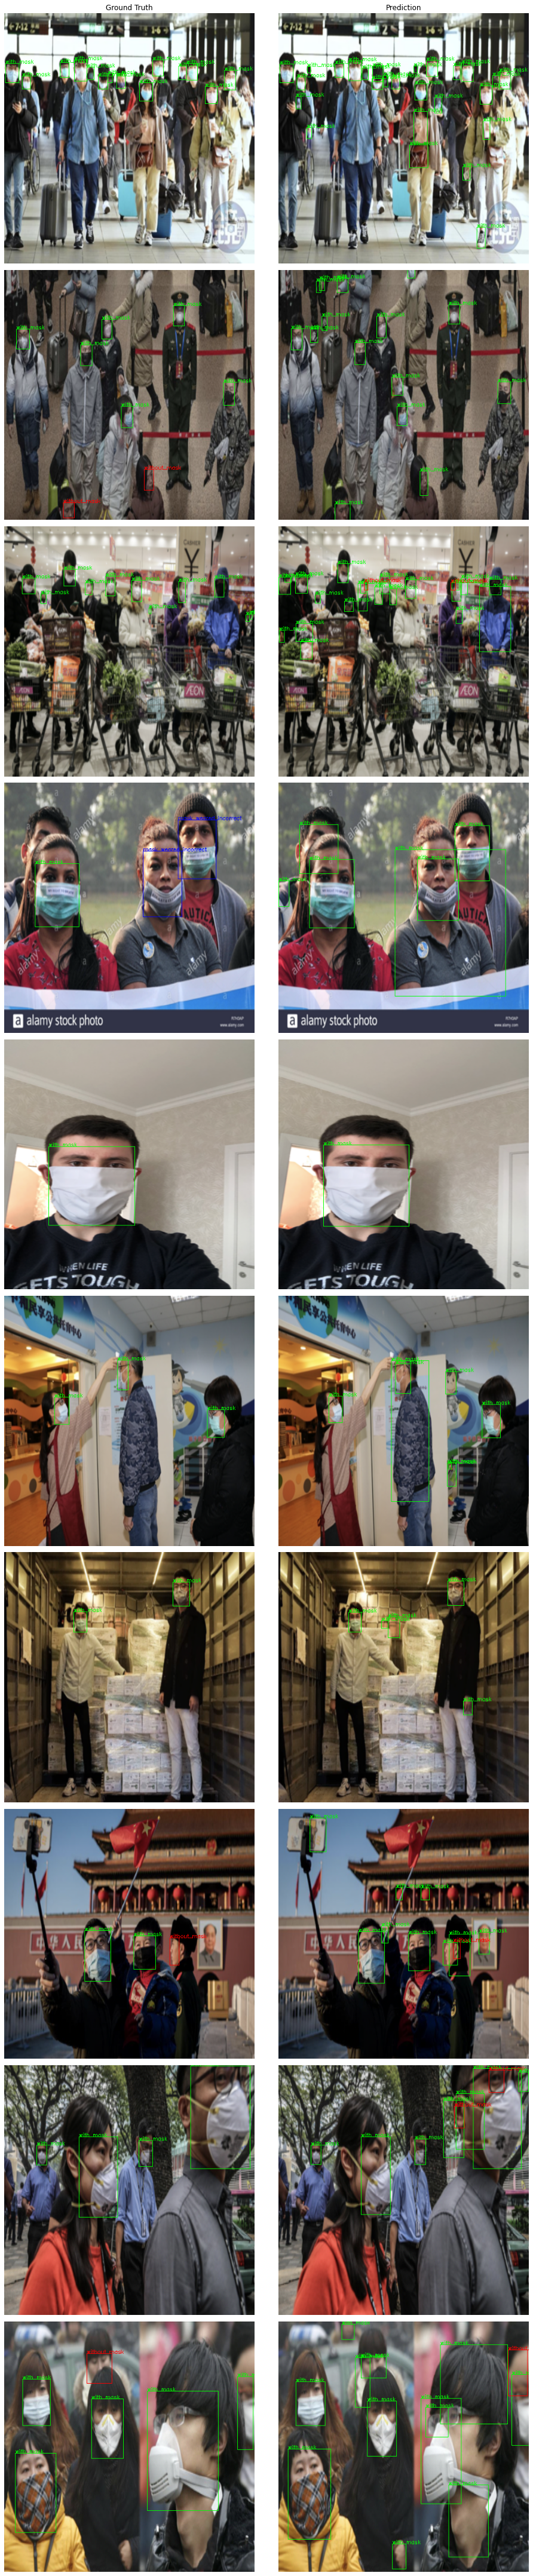

In [32]:
plot_test_examples(model, dataloaders['valid'])
# plot_test_examples(model, dataloaders['train'])
